In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.feature_selection import RFECV
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb
import seaborn as sns
from tqdm import tqdm

from imblearn.over_sampling import SMOTE, ADASYN


Mounted at /content/drive


# Baseline

Let's analyze the distribution of the variable y (response variable) by looking at the frequency of instances for each class.

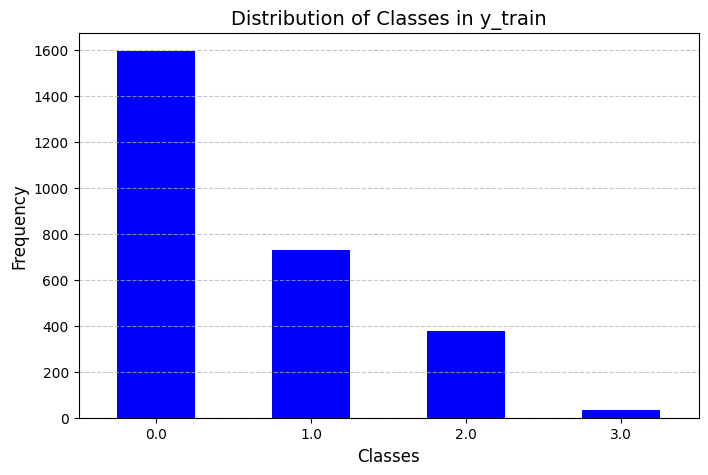

Baseline (Stupid Predictor Accuracy): 0.583


In [ ]:
train_data = pd.read_csv('./Data/train_.csv')
test_data = pd.read_csv('./Data/test_.csv')

# Put the "sii" column in y
y = train_data['sii']

test_data = test_data.drop(columns=['id'])

# Modify the training set to consider only the columns that are also present in the test set
common_columns = train_data.columns.intersection(test_data.columns)

X = train_data[common_columns]
test_data = test_data[common_columns]

y = y.dropna()

# Count the frequency of each class
class_counts = y.value_counts()

# Plot the distribution graph
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color='blue')
plt.title('Distribution of Classes in y_train', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# "Stupid" predictor, baseline, simply predict the most frequent class
baseline_accuracy = class_counts.max() / class_counts.sum()
print(f"Baseline (Stupid Predictor Accuracy): {baseline_accuracy:.3f}")

## Conclusions

We can notice that in the response variable, the frequency of the classes is strongly imbalanced, so it can be inferred that appropriate methods will need to be used for the construction of a classifier.

The main techniques that can be used when dealing with an imbalanced dataset are:
  - Oversampling the minority class
  - Undersampling the majority class
      - We will not use this method, as the dataset at our disposal is not very large and we risk losing important information
  - Assigning weights to the classes that are inversely proportional to their frequency, this can be done during the use of Decision Tree (class weight = 'balanced')
  - Use of Ensemble methods, such as Random Forest, these models are designed to automatically balance the data during training

# Data preparation

- Processing of numerical features, with conversion, handling of Nans, and creation of binary columns.
- Encoding of categorical features with LabelEncoder.
- Filtering of common columns between train and test to avoid mismatches.
- Splitting the data into train, validation, and test sets for proper training and evaluation of models.

In [3]:
'''   Module for data preparation  '''


def process_data(train, test):
    # Identify numerical and categorical features
    numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = train.select_dtypes(include=['object']).columns

    '''
    Identify numerical columns (with >10 distinct values), (a column containing numerical data
    could still be categorical)'''
    is_numerical = np.array([len(np.unique(train[col].dropna())) > 10 for col in numerical_columns])
    numerical_idx = np.flatnonzero(is_numerical)

    # Processing numerical features
    X_train = pd.concat([
        train.iloc[:, numerical_idx].apply(pd.to_numeric, errors='coerce'),  # Convert to numeric, set NaN where it fails
        train.iloc[:, numerical_idx].isna().astype(int)                      # Create binary columns (only for numerical columns) where there are NaNs
    ], axis=1).fillna(0.0)  # Replace NaNs with 0.0

    # Encoding categorical features with LabelEncoder
    categorical_idx = np.flatnonzero(is_numerical == False)
    label_encoders = {}

    # categorical_idx is used to select only categorical columns
    for col in train.iloc[:, categorical_idx].columns:
        # Create a LabelEncoder for each column, each specific to one column
        le = LabelEncoder()

        ''' Train the LabelEncoder on the current column of the training set, first converting the values to
        strings with .astype(str) (necessary to avoid errors in case of mixed types). During training,
        the LabelEncoder stores all unique categories of the column and assigns them a unique integer '''
        le.fit(train[col].astype(str))  # Convert to string to avoid issues with NaNs or mixed types

        # Save the trained LabelEncoder in a dictionary where the key is the column name
        label_encoders[col] = le

        # Transform categorical values using the trained encoder
        train[col] = le.transform(train[col].astype(str))

    # Add encoded categorical columns to the training set (which is the X_train dataframe)
    X_train = pd.concat([X_train, train.iloc[:, categorical_idx]], axis=1)



    # Pre-process numerical features for the test set
    X_test = pd.concat([
        test.iloc[:, numerical_idx].apply(pd.to_numeric, errors='coerce'),  # Convert to numeric, set NaN where it fails
        test.iloc[:, numerical_idx].isna().astype(int)                      # Create binary columns where there are NaNs
    ], axis=1).fillna(0.0)  # Replace NaNs with 0.0

    for col in test.iloc[:, categorical_idx].columns:
        le = label_encoders[col]  # Use the same LabelEncoder trained on the training set

        test[col] = test[col].astype(str)

        ''' Compare the categories present in the test set column (test[col].unique()) with those
        known to the LabelEncoder (le.classes_).
        unseen_labels will contain the categories that the LabelEncoder has never encountered. '''
        unseen_labels = set(test[col].unique()) - set(le.classes_)
        if unseen_labels:
            # Add the list of unseen labels to the LabelEncoder
            le.classes_ = np.append(le.classes_, list(unseen_labels))

        test[col] = le.transform(test[col])  # Transform the data in the test set

    # Add encoded categorical columns to the test set
    X_test = pd.concat([X_test, test.iloc[:, categorical_idx]], axis=1)

    return X_train, X_test



def data_preprocessing(train_data, test_data):
    # Put the "sii" column in y
    y = train_data['sii']

    test_data = test_data.drop(columns=['id'])

    # Modify the training set to consider only the columns that are also present in the test set
    common_columns = train_data.columns.intersection(test_data.columns)

    X = train_data[common_columns]
    test_data = test_data[common_columns]

    # Split into train and test (random split, ensuring both sets are representative)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

    X_train_enc, X_test_enc = process_data(X_train, X_test)

    # Process the data (X_train_enc and X_test_enc)

    # Remove rows with NaN values in y_train and y_test
    valid_rows_train = ~y_train.isna()  # Identify valid rows in y_train
    valid_rows_test = ~y_test.isna()    # Identify valid rows in y_test

    # Filter X_train, X_test, and y by removing NaNs in y
    X_train = X_train[valid_rows_train]
    y_train = y_train[valid_rows_train]
    X_test = X_test[valid_rows_test]
    y_test = y_test[valid_rows_test]

    # Synchronize processed datasets with filtered labels
    X_train_enc = X_train_enc.loc[y_train.index]
    X_test_enc = X_test_enc.loc[y_test.index]

    # Split into train and validation, then test the algorithm
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_enc, y_train,
                                                          test_size=0.25, random_state=42)

    return X_train, X_valid, X_test_enc, y_train, y_valid, y_test

# Decision Tree Classifier

In [ ]:
train_data = pd.read_csv('./Data/train_.csv')
test_data = pd.read_csv('./Data/test_.csv')

X_train, X_valid, X_test, y_train, y_valid, y_test = data_preprocessing(train_data, test_data)

In [5]:
def accuracies_vary_max_leaves(X_train, X_valid, X_test, y_train, y_valid, y_test,
                              l_min=2, l_max=50, l_step=1):

    accuracies = []

    for max_leaves in range(l_min,l_max, l_step):
        # train and predict
        dt = DecisionTreeClassifier(max_leaf_nodes=max_leaves, random_state=42)
        dt.fit(X_train,y_train)

        # compute Accuracy
        train_acc = accuracy_score(y_true=y_train, y_pred=dt.predict(X_train))
        valid_acc = accuracy_score(y_true=y_valid, y_pred=dt.predict(X_valid))
        test_acc  = accuracy_score(y_true=y_test,  y_pred=dt.predict(X_test))

        accuracies += [ [max_leaves, train_acc, valid_acc, test_acc] ]

    accuracies = np.array(accuracies)

    fig, ax = plt.subplots()
    ax.plot(accuracies[:,0], accuracies[:,1], "x:", label="Train")
    ax.plot(accuracies[:,0], accuracies[:,2], "o-", label="Valid")
    ax.plot(accuracies[:,0], accuracies[:,3], "s-", label="Test")
    ax.legend()
    ax.grid()

    return accuracies

array([[ 2.        ,  0.60159074,  0.55194805,  0.56902357],
       [ 3.        ,  0.60448301,  0.56060606,  0.56004489],
       [ 4.        ,  0.61532899,  0.54978355,  0.5701459 ],
       [ 5.        ,  0.61532899,  0.54978355,  0.5701459 ],
       [ 6.        ,  0.61532899,  0.54978355,  0.5701459 ],
       [ 7.        ,  0.61605206,  0.56060606,  0.57126824],
       [ 8.        ,  0.62039046,  0.55844156,  0.57126824],
       [ 9.        ,  0.62039046,  0.55844156,  0.57126824],
       [10.        ,  0.62834418,  0.56060606,  0.56790123],
       [11.        ,  0.63268257,  0.56060606,  0.5634119 ],
       [12.        ,  0.63268257,  0.56060606,  0.5634119 ],
       [13.        ,  0.63485177,  0.55844156,  0.56228956],
       [14.        ,  0.64569776,  0.55844156,  0.5701459 ],
       [15.        ,  0.64569776,  0.55844156,  0.5701459 ],
       [16.        ,  0.65292842,  0.55411255,  0.56116723],
       [17.        ,  0.65582068,  0.55411255,  0.56116723],
       [18.        ,  0.

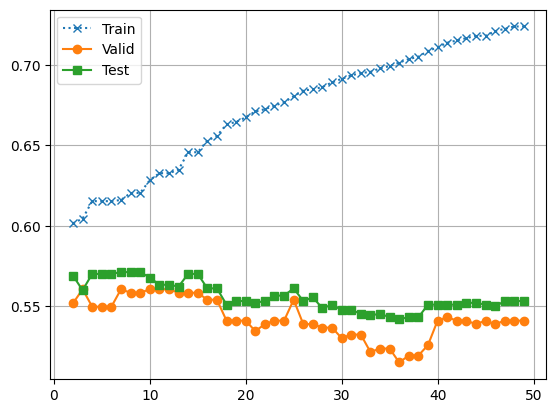

In [6]:
accuracies_vary_max_leaves(X_train, X_valid, X_test,
                           y_train, y_valid, y_test,
                           l_min=2, l_max=50)

In [7]:
dt = DecisionTreeClassifier( max_leaf_nodes=3, random_state=42)

dt.fit(X_train,y_train)

test_acc  = accuracy_score(y_true=y_test,  y_pred=dt.predict(X_test))


print (f"Test Acc : {test_acc:.3f}" )

Test Acc : 0.560


# Random forest

In [ ]:
train_data = pd.read_csv('./Data/train_.csv')
test_data = pd.read_csv('./Data/test_.csv')

X_train, X_valid, X_test, y_train, y_valid, y_test = data_preprocessing(train_data, test_data)

Results of accuracies for each number of trees:


,Number of Trees,Training Accuracy,Test Accuracy,Cross-Validation Accuracy
0,1,0.805495,0.472503,0.488762
1,5,0.926247,0.533109,0.553885
2,10,0.978308,0.538721,0.581358
3,25,0.991323,0.545455,0.587849
4,30,0.994215,0.553311,0.590025
5,35,0.994215,0.553311,0.592918
6,40,0.995662,0.555556,0.600141
7,45,0.995662,0.552189,0.600869
8,50,0.994939,0.552189,0.605925


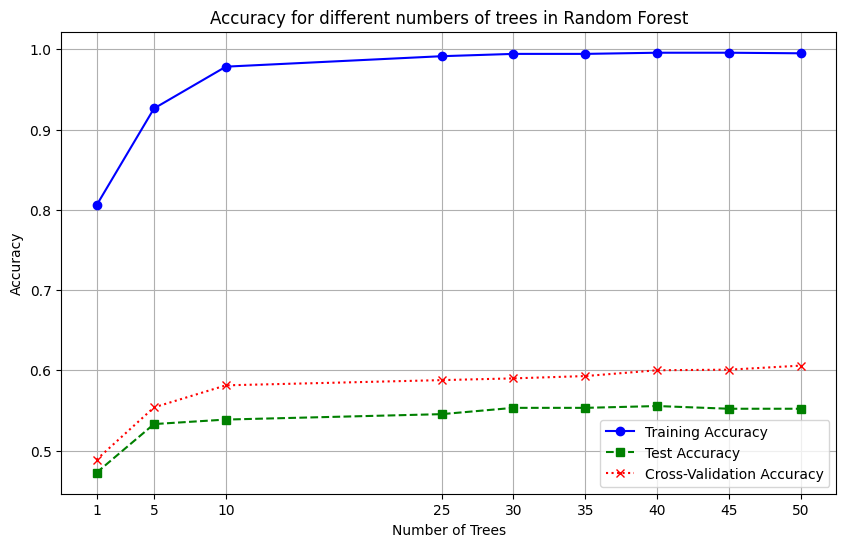

In [ ]:

# List of tree numbers to try
n_trees = [1, 5, 10, 25, 30, 35, 40, 45, 50]

# Lists to store the accuracies of each model
train_accuracies = []
test_accuracies = []
cv_accuracies = []  # Store cross-validation accuracies

# Loop to try different Random Forest models with various numbers of trees
for t in n_trees:
    # Initialize the Random Forest model with t trees and balanced class weights
    rf = RandomForestClassifier(n_estimators=t, class_weight='balanced', random_state=42)

    # Train the model
    rf.fit(X_train, y_train)

    # Compute the accuracies for training and test sets
    train_acc = accuracy_score(y_true=y_train, y_pred=rf.predict(X_train))
    test_acc = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))

    # Perform cross-validation (e.g., 5-fold)
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

    # Store the results
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    cv_accuracies.append(scores.mean())  # Store average CV accuracy

# Create a DataFrame to display the results in tabular format
results_df = pd.DataFrame({
    'Number of Trees': n_trees,
    'Training Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Cross-Validation Accuracy': cv_accuracies
})
print("Results of accuracies for each number of trees:")
display(results_df)

# Display the results in a chart
plt.figure(figsize=(10, 6))
plt.plot(n_trees, train_accuracies, marker='o', color='blue', linestyle='-', label='Training Accuracy')
plt.plot(n_trees, test_accuracies, marker='s', color='green', linestyle='--', label='Test Accuracy')
plt.plot(n_trees, cv_accuracies, marker='x', color='red', linestyle=':', label='Cross-Validation Accuracy')  # Add CV line
plt.title("Accuracy for different numbers of trees in Random Forest")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.xticks(n_trees)
plt.legend()
plt.grid(True)
plt.show()


In [10]:
''' Tree with best accuracy: '''
rf = RandomForestClassifier(n_estimators=40, class_weight='balanced', random_state=42)

rf.fit(X_train, y_train)

test_acc  = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))


print(f"Test Acc : {test_acc:.3f}")

Test Acc : 0.556


Classi codificate: [0. 1. 2. 3.]


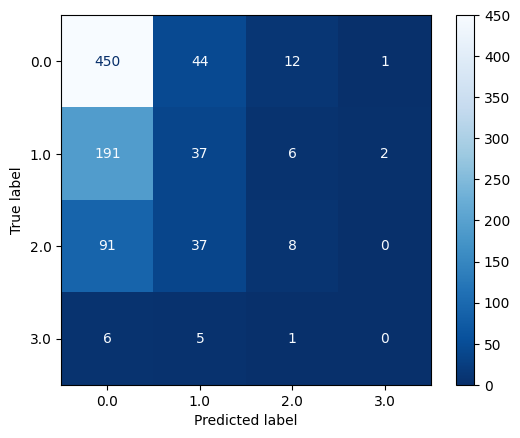

In [11]:
''' Let's investigate the performance of the Random Forest model more thoroughly using the confusion matrix. '''

label_enc = LabelEncoder()
label_enc.fit_transform(y_train)

ConfusionMatrixDisplay.from_estimator(
    estimator=rf,  #specifica il modello di classificazione
    X=X_test, y=y_test,
    display_labels=label_enc.classes_,
    cmap = 'Blues_r');


print("Classi codificate:", label_enc.classes_)

In [12]:
'''
analysis of metrics: precision, recall, and F1-score for each class
'''
report = classification_report(y_true=y_test, y_pred=rf.predict(X_test))
print(report)

              precision    recall  f1-score   support

         0.0       0.61      0.89      0.72       507
         1.0       0.30      0.16      0.21       236
         2.0       0.30      0.06      0.10       136
         3.0       0.00      0.00      0.00        12

    accuracy                           0.56       891
   macro avg       0.30      0.28      0.26       891
weighted avg       0.47      0.56      0.48       891



### Conclusions/Deductions from the report and confusion matrix analysis:

**Class 0:** This class achieved good scores in all three metrics. We can say that the model performs well for class 0, likely because it's the class containing the most samples, and therefore the model has more examples to learn from.

**Class 1:** Metrics for this class have fairly low values, especially recall. This is because many examples of class 1 are predicted as belonging to other classes (often class 0, as it's the dominant class).

**Class 2:** This class has very low values for all metrics (especially recall). Despite these low scores, we can see that this class is not extremely under-represented, with 136 samples. The model recognizes only 4% of actual samples belonging to class 2. It's possible that this class has characteristics too similar to other classes (e.g., class 0, the most represented), as it was confused with class 0   102 times.

**Class 3:** This class has 0 in all metrics, likely because it's extremely under-represented. Looking at the support, we see only 12 samples, so it's normal that the model hasn't "learned" to recognize it. (Consider trying the XGBoost model).

**In summary:** The model performs well on the most represented class (0), but struggles with the others (particularly 2 and 3). Class 3 has too few samples. Given that we're in a mental health context, and therefore something related to the medical field, the fact that the model rarely captures classes 2 and 3, which represent the most severe cases, drastically reduces its practical usefulness.

**Next step:** Feature analysis.....

Number of features before selection: 85
Number of features after selection: 71
Set of selected features:
Index(['Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height',
       'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Time_Mins', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone',
       'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI',
       'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW',
       'BIA-BIA_LDM', 'BIA-BIA_LST', 'CGAS-Season', 'CGAS-CGAS_Score',
       'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
       'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
       'Physical-HeartRate', 'Physical-Systolic_BP',
    

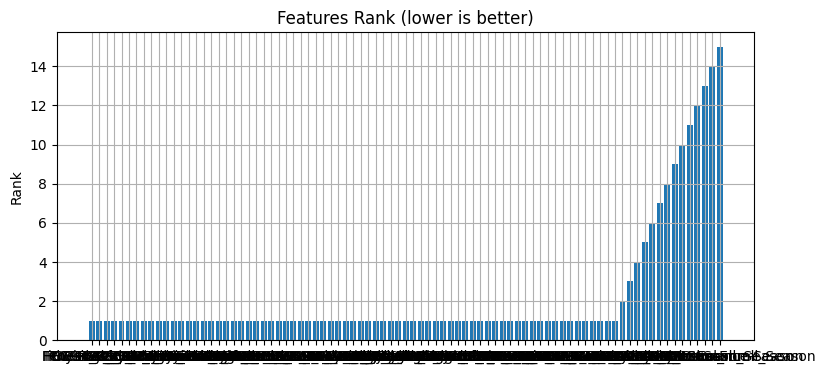

In [14]:

''' Selection of the most relevant features, displaying the features on-screen in order of importance '''

''' Recursive Feature Elimination with Cross-Validation (RFECV) '''

# Get the number of features before selection
num_features_before = X_train.shape[1]
print(f"Number of features before selection: {num_features_before}")

selector = RFECV(rf,
                 step=1,  # Removes one feature at a time during the elimination process
                 cv=5,    # Cross-validation folds
                 scoring='accuracy',  # Uses accuracy as the evaluation metric
                 min_features_to_select=1  # Ensures that at least one feature is selected
                )

# Fit RFE to your data
selector.fit(X_train, y_train)

# Print the number of selected features
num_features_after = selector.n_features_
print(f"Number of features after selection: {num_features_after}")

# Get feature names from your training data
feature_names = X_train.columns

# Print the selected features
print("Set of selected features:")
print(feature_names[selector.support_])

# Get the best accuracy score
best_accuracy = selector.cv_results_['mean_test_score'].max()  # Use cv_results_ instead of grid_scores_
print(f"Best accuracy obtained: {best_accuracy:.3f}")


# Create the feature ranking plot
fig, ax = plt.subplots(figsize=(9, 4))
ax.bar(range(0, X_train.shape[1]), sorted(selector.ranking_))
ax.set_title("Features Rank (lower is better)")
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(feature_names[np.argsort(selector.ranking_)])
ax.set_ylabel("Rank")
ax.grid()
plt.show()

Full score: 0.58
Best score: 0.60


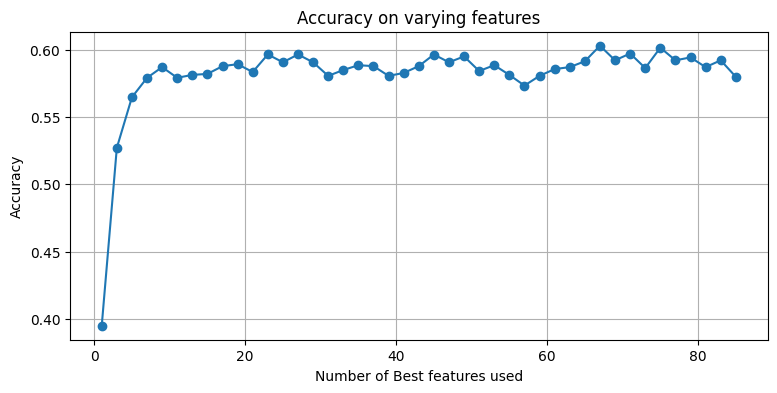

In [ ]:

# Progressive evaluation of each feature's contribution in a Random Forest model
# Contains the feature importance scores; np.argsort() sorts the indices of the features,
best_features = np.argsort(rf.feature_importances_)[::-1]  # [::-1] reverses the order, sorting indices in descending order
# To record the average accuracy (RMSE - mean squared error is mentioned, but here we compute accuracy)
accuracy = []
for f in range(1, len(best_features) + 1, 2):
    rf_small = RandomForestClassifier(n_estimators=40, class_weight='balanced', random_state=42)  # Use RandomForestClassifier
    rf_small.fit(X_train.iloc[:, best_features[:f]], y_train)  # Fit the model with selected features
    scores = cross_val_score(rf_small,
                             X_train.iloc[:, best_features[:f]], y_train,  # Use X_train with selected features
                             cv=5, scoring='accuracy')  # Using accuracy as the scoring metric
    accuracy += [scores.mean()]   # Calculate the mean of the various accuracies obtained
print(f"Full score: {accuracy[-1]:.2f}")
print(f"Best score: {max(accuracy):.2f}")

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(range(1, len(best_features) + 1, 2), accuracy, 'o-', label="Accuracy")
ax.set_title("Accuracy on varying features")
ax.set_xlabel("Number of Best Features Used")
ax.set_ylabel("Accuracy")
ax.grid()
plt.show()

Test Accuracy with selected features: 0.557
              precision    recall  f1-score   support

         0.0       0.61      0.89      0.72       507
         1.0       0.33      0.14      0.20       236
         2.0       0.23      0.07      0.11       136
         3.0       0.25      0.08      0.12        12

    accuracy                           0.56       891
   macro avg       0.35      0.30      0.29       891
weighted avg       0.47      0.56      0.48       891



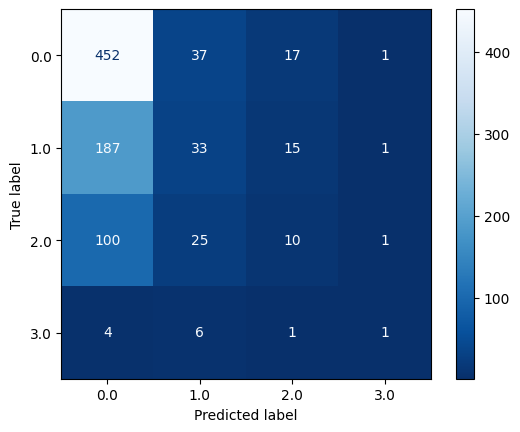

In [15]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Assuming 'feature_names' and 'selector' are defined from the previous code

# Get the selected features
selected_features = feature_names[selector.support_]

# Create a new RandomForestClassifier with the selected features
rf_selected = RandomForestClassifier(n_estimators=40, class_weight='balanced', random_state=42)

# Train the model with the selected features
rf_selected.fit(X_train[selected_features], y_train)

# Make predictions on the test set using the selected features
y_pred_selected = rf_selected.predict(X_test[selected_features])

# Evaluate the model with selected features
test_acc_selected = accuracy_score(y_true=y_test, y_pred=y_pred_selected)
print(f"Test Accuracy with selected features: {test_acc_selected:.3f}")

# Generate the classification report
report_selected = classification_report(y_true=y_test, y_pred=y_pred_selected)
print(report_selected)

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(
    estimator=rf_selected,  # Use the model trained with selected features
    X=X_test[selected_features], y=y_test,
    display_labels=label_enc.classes_,  # Assuming label_enc is defined from previous code
    cmap='Blues_r');

# XGBoost

Unlike previous approaches, XGBoost handles missing values natively, so data preprocessing is slightly modified.

The following steps will be performed:

1. **Data preprocessing specific to XGBoost:** Adapting the preprocessing to handle missing values appropriately for XGBoost.
2. **Search for optimal hyperparameters:** Using RandomizedSearchCV to identify the best combination of hyperparameters for XGBoost, balancing accuracy and computation time.
3. **Model training and evaluation:** Training the XGBoost model with the optimal hyperparameters and evaluating its performance on validation and test sets, using the confusion matrix and classification report for a detailed analysis.

The goal is to evaluate whether XGBoost, with its robustness and flexibility, can provide a more accurate and performant model.

In [16]:

def process_data_XG(train, test):
    '''
    Almost identical to the implementation for the other models, except that this one is for
    XGBoost and therefore the NaN values are left unchanged.
    '''
    # Identify numerical and categorical features
    numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = train.select_dtypes(include=['object']).columns

    # Identify numerical columns (with >10 distinct values)
    is_numerical = np.array([len(np.unique(train[col].dropna())) > 10 for col in numerical_columns])
    numerical_idx = np.flatnonzero(is_numerical)

    # Processing of numerical features (without converting NaN)
    X_train = train.iloc[:, numerical_idx].apply(pd.to_numeric, errors='coerce')

    # Encoding of categorical features with LabelEncoder
    categorical_idx = np.flatnonzero(is_numerical == False)
    label_encoders = {}

    for col in train.iloc[:, categorical_idx].columns:
        le = LabelEncoder()
        le.fit(train[col].astype(str))
        label_encoders[col] = le
        train[col] = le.transform(train[col].astype(str))

    X_train = pd.concat([X_train, train.iloc[:, categorical_idx]], axis=1)

    # Preprocessing of numerical features for the test set (without converting NaN)
    X_test = test.iloc[:, numerical_idx].apply(pd.to_numeric, errors='coerce')

    for col in test.iloc[:, categorical_idx].columns:
        le = label_encoders[col]
        test[col] = test[col].astype(str)
        unseen_labels = set(test[col].unique()) - set(le.classes_)
        if unseen_labels:
            le.classes_ = np.append(le.classes_, list(unseen_labels))
        test[col] = le.transform(test[col])

    X_test = pd.concat([X_test, test.iloc[:, categorical_idx]], axis=1)

    return X_train, X_test




def data_preprocessing_XG(train_data, test_data):

    # Assign the "sii" column to y
    y = train_data['sii']

    test_data = test_data.drop(columns=['id'])

    # Modify the training set to only consider the columns that are also present in the test set
    common_columns = train_data.columns.intersection(test_data.columns)

    X = train_data[common_columns]
    test_data = test_data[common_columns]

    # Splitting into train and test (random split, ensuring that both sets are representative)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

    X_train_enc, X_test_enc = process_data_XG(X_train, X_test)

    # Process the data (X_train_enc and X_test_enc)

    # Remove rows with NaN values in y_train and y_test
    valid_rows_train = ~y_train.isna()  # Identify valid rows in y_train
    valid_rows_test = ~y_test.isna()    # Identify valid rows in y_test

    # Filter X_train, X_test, and y by removing NaNs in y
    X_train = X_train[valid_rows_train]
    y_train = y_train[valid_rows_train]
    X_test = X_test[valid_rows_test]
    y_test = y_test[valid_rows_test]

    # Synchronize processed datasets with filtered labels
    X_train_enc = X_train_enc.loc[y_train.index]
    X_test_enc = X_test_enc.loc[y_test.index]

    # First split into train and validation, then test the algorithm
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_enc, y_train, test_size=0.25, random_state=42)

    return X_train, X_valid, X_test_enc, y_train, y_valid, y_test



In [ ]:
train_data = pd.read_csv('./Data/train_.csv')
test_data = pd.read_csv('./Data/test_.csv')

X_train, X_valid, X_test, y_train, y_valid, y_test = data_preprocessing_XG(train_data, test_data)

In [ ]:

'''
Find the best parameters for the XGBoost model,  to reduce training time
I use RandomizedSearchCV instead of GridSearchCV.
'''

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)

# Define the hyperparameter grid to test
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

for params in tqdm(param_grid):
  random_search = RandomizedSearchCV(
      estimator=xgb_model,
      param_distributions=param_grid,
      scoring='accuracy',
      cv=5,
      n_iter=30,  # Number of random combinations to test
      random_state=42,
      verbose=1,
      n_jobs=-1
  )
  # Train the model with GridSearchCV
  random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print(random_search.best_params_)

In [18]:
'''
Train the XGBoost model with the best parameters found
'''

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)

# Define the hyperparameter grid to test
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],   # how much each tree contributes to the model (lower values make the model more robust, but training is slower)
    'max_depth': [3, 5, 7],   # maximum depth of each tree (deeper trees capture more details, but risk overfitting)
    'n_estimators': [50, 100, 150],  # number of trees to create
    'subsample': [0.8, 0.9, 1.0],   # fraction of samples to use for training each tree
    'colsample_bytree': [0.8, 0.9, 1.0]  # fraction of features to use for training each tree
}

# Let's assume these are the best parameters found from a previous run
best_params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 50,
    'subsample': 0.8,
    'colsample_bytree': 0.9
}

'''
Here I manually set the parameters in the model, to avoid running the RandomizedSearchCV again,
since it takes too much time.
'''
# Create a RandomizedSearchCV object (but do not execute the search)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,  # param_grid is still required
    scoring='accuracy',
    cv=5,
    n_iter=1,  # Set to 1 to avoid fitting; this is used to simulate a single fit.
    random_state=42,
    verbose=0,
    n_jobs=-1
)

# Manually set the best parameters
random_search.best_params_ = best_params

# Now you can use random_search.best_params_ as before
# for example:
# best_xgb_model = xgb.XGBClassifier(**random_search.best_params_, objective='multi:softmax', num_class=4, random_state=42)
# best_xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:51:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 0.5562770562770563
Test Accuracy: 0.5578002244668911


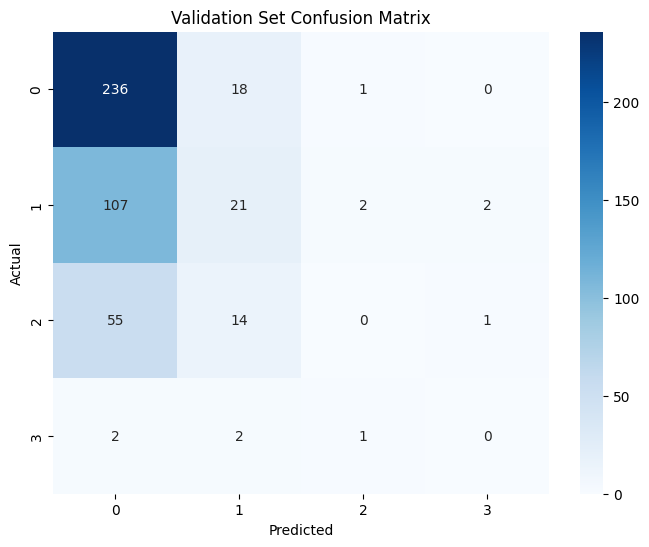

              precision    recall  f1-score   support

         0.0       0.59      0.93      0.72       255
         1.0       0.38      0.16      0.22       132
         2.0       0.00      0.00      0.00        70
         3.0       0.00      0.00      0.00         5

    accuracy                           0.56       462
   macro avg       0.24      0.27      0.24       462
weighted avg       0.43      0.56      0.46       462


Analysis for Validation Set Confusion Matrix:


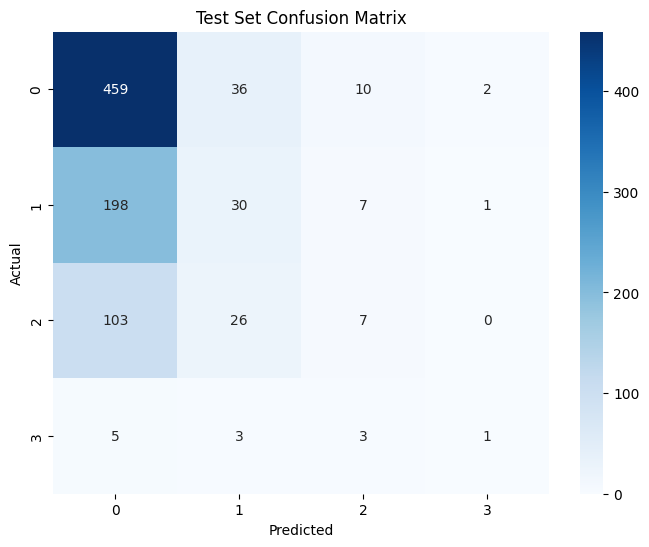

              precision    recall  f1-score   support

         0.0       0.60      0.91      0.72       507
         1.0       0.32      0.13      0.18       236
         2.0       0.26      0.05      0.09       136
         3.0       0.25      0.08      0.12        12

    accuracy                           0.56       891
   macro avg       0.36      0.29      0.28       891
weighted avg       0.47      0.56      0.47       891


Analysis for Test Set Confusion Matrix:


In [19]:
'''
Model testing, both with validation and test sets. Then, analysis of the results...
'''

classes = np.unique(y_train)  # Assuming y_train contains your training labels

best_params = random_search.best_params_

best_xgb_model = xgb.XGBClassifier(**best_params, class_weight='balanced', objective='multi:softmax', num_class=4, random_state=42)
best_xgb_model.fit(X_train, y_train)

# validation
y_pred_valid = best_xgb_model.predict(X_valid)
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print(f"Validation Accuracy: {accuracy_valid}")

# test
y_pred_test = best_xgb_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test}")

# **Confusion Matrix and Analysis**
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(classification_report(y_true, y_pred))  # Print classification report with precision, recall, and f1-score

    # **Analysis (Example)**
    print(f"\nAnalysis for {title}:")
    # Add specific analysis points based on the confusion matrix
    # Example:
    # print(f"  - Most frequent misclassification: Class {cm.argmax()} predicted as Class {cm.argmin()}")

plot_confusion_matrix(y_valid, y_pred_valid, "Validation Set Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_test, "Test Set Confusion Matrix")



#accuracy = accuracy_score(y_test_enc, y_pred)  # oppure y_valid se usi il validation set

# Stampa l'accuracy
#print(f"Accuracy: {accuracy}")